In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy.io import fits

from ekfplot import plot as ek
from ekfplot import colors as ec

from agrias import utils
import reader

In [3]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))
ms = reader.merianselect ( merian )#, av=0.29)

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:54: RuntimeWarning: overflow encountered in power
  av = 10.**np.poly1d(saga_gr_av_coeffs)(gr)


In [126]:
use_galex_direct = True

if use_galex_direct:
    _galex = pd.read_csv('../local_data/output/galex_photometry.csv', index_col=0)
else:
    _galex = reader.galexcrossmatch ()    
    
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

if not use_galex_direct:
    _galex = _galex.sort_values('fuv_exptime', ascending=False)
galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap)#.reset_index()

if use_galex_direct:
    galex['fuv_mag'] = -2.5*np.log10(galex['flux_fuv']/3631.)
    galex['nuv_mag'] = -2.5*np.log10(galex['flux_nuv']/3631.)
#merian_sources = table.Table.from_pandas(merian_sources.reset_index())

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [127]:
out = reader.compute_halphacorrections(merian_sources, use_dustengine=False)
emission_correction, ge_correction, dust_correction, aperture_correction = out

Computed line contamination in 0.0 seconds.
Computed Galactic extinction in 0.1 seconds.
Computed internal extinction in 0.1 seconds.
Computed aperture correction in 0.0 seconds.


In [128]:
galex = reader.galex_luminosities ( galex, merian_sources['z_phot'].values, ge_correction, dust_correction )
galex = galex.to_pandas()

In [130]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)

In [131]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(merian_sources.index)
print(lha_df.dropna().shape)

(14138, 4)


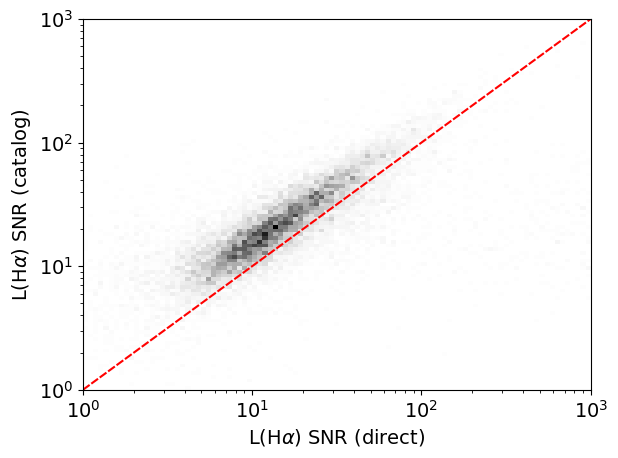

In [132]:
direct_snr = (lha_df['LHa']/lha_df['u_LHa']).reindex(catalog_halum.index)
catalog_snr = catalog_halum['LHa']/catalog_halum['u_LHa']
ek.hist2d(
    direct_snr,
    catalog_snr,
    bins=np.logspace(0, 3,100)
)
xs = np.logspace(0,3,100)
plt.plot(xs,xs,color='r', dashes = [4,1])
ek.loglog()
plt.xlabel(r'L(H$\alpha$) SNR (direct)')
plt.ylabel(r'L(H$\alpha$) SNR (catalog)')
plt.tight_layout ()
plt.savefig('/Users/kadofong/Desktop/direct_v_catalog_snr.png')

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


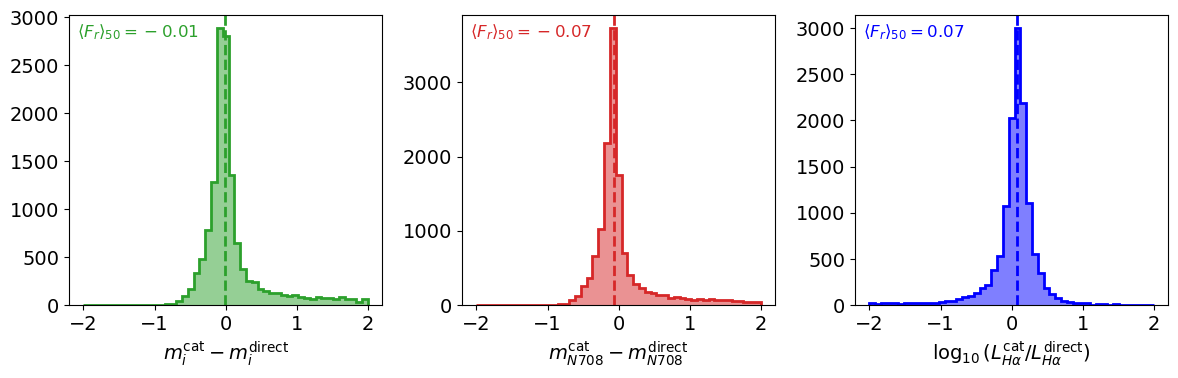

In [133]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
catalog_apercorr = merian_sources['i_cModelFlux_Merian'] / merian_sources['i_gaap1p0Flux_Merian']
f2m = lambda x, zp = 31.4: -2.5*np.log10(x*catalog_apercorr) + zp
ratios = [
    merian_sources['i_cModelmag_Merian'] - lha_df.reindex(merian_sources.index)['imag'],
    f2m(merian_sources['N708_gaap1p0Flux_Merian']) - lha_df.reindex(merian_sources.index)['n708mag'],    
    np.log10(catalog_halum['LHa']/1e40/lha_df.reindex(catalog_halum.index)['LHa']),
    #np.log10(calibrations.SFR2LHa(10.**merian_sources['logsfr_gaap1p0']) / (lha_df['LHa']*1e40) )
]
colorlist = [
    'tab:green',
    'tab:red',
    'b'
]
labels = [
    r'$m_i^{\rm cat} - m_i^{\rm direct}$',
    r'$m_{N708}^{\rm cat} - m_{N708}^{\rm direct}$',
    r'$\log_{10}(L_{H\alpha}^{\rm cat}/L_{H\alpha}^{\rm direct})$'
]

for idx, ax in enumerate(axarr):
    ek.hist( 
        ratios[idx],
        bins=np.linspace(-2.,2.,50),
        ax=axarr[idx],
        color=colorlist[idx],
        alpha=0.5,
        lw=2
    )    
    axarr[idx].axvline(
        np.nanmedian(ratios[idx]),
        color=colorlist[idx],
        lw=2,
        ls='--'
    )
    ek.text(
        0.025,
        0.975,        
        r'$\langle F_r \rangle_{50} = %.2f$' % np.nanmedian(ratios[idx]),
        ax=axarr[idx],
        color=colorlist[idx],
        fontsize=12
    )
    axarr[idx].set_xlabel(labels[idx])   
plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/photometric_offsets.png')

In [77]:
from ekfphys import calibrations, observer
from ekfparse import query

In [134]:
rv = 3.1
ge_av = merian_sources['ebv_Merian']*rv

In [135]:
gecorr = np.zeros([len(ge_av),2])
for idx,row in enumerate(ge_av.values):
    gecorr[idx] = -observer.gecorrection(np.array([4758.71,6135.]), row, return_magcorr=True)


In [136]:
ref = np.genfromtxt('/Users/kadofong/Desktop/ref.txt')

Text(0, 0.5, 'g-r')

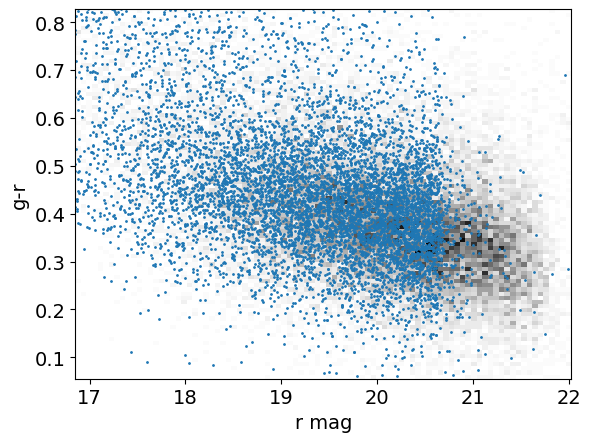

In [137]:
apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_Merian']
flux = merian_sources.loc[:,utils.photcols['r']]*apercorr
gr = -2.5*np.log10(merian_sources[utils.photcols['g']]/merian_sources[utils.photcols['r']]) + gecorr[:,0] - gecorr[:,1]
merian_rmag = -2.5*np.log10(flux) + 31.4

_=ek.hist2d(
    merian_rmag,
    gr,
    bins=90, 
)
plt.scatter(
    ref[3],
    ref[2]-ref[3],
    s=1,
)
#plt.xlim(7., 11.2)
plt.xlabel('r mag')
plt.ylabel('g-r')

In [138]:
lee = table.Table.read('/Users/kadofong/work/projects/literature_ref/lee2009/tab1_processed.txt', format='mrt')
leer = lee['loghalum'] - lee['loguvlum']

In [194]:
merr = np.log10(lha_df['LHa']*1e40 / galex.reindex(lha_df.index)['LFUV'])
hasnr = lha_df['LHa']/lha_df['u_LHa']
uvsnr = (galex['LFUV']/galex['u_LFUV']).reindex(lha_df.index)
#merr = np.where(np.isfinite(merr),merr, np.NaN)

In [217]:
low = np.genfromtxt("/Users/kadofong/Desktop/tmp.dat", dtype=str)

In [237]:
mask = merr>13.6
mask &= lha_df.reindex(merr.index)['n708mag'] < 21.

merian_sources.loc[mask].reset_index().rename({'index':'NAME'}, axis=1)[['NAME','RA','DEC']].to_csv('/Users/kadofong/Desktop/tmpcat.csv', index=False)


In [248]:
cat_galex = reader.galexcrossmatch ()

In [250]:
cat_galex.loc['M3460277441820373040']['fuv_mag']

21.04824

In [245]:
galex.loc['M3460277441820373040'][['fuv_mag']]

fuv_mag    20.909419
Name: M3460277441820373040, dtype: float64

In [242]:
lha_df.loc['M3460277441820373040']

LHa        237.253770
u_LHa        0.194256
imag        17.016095
n708mag     15.947401
Name: M3460277441820373040, dtype: float64

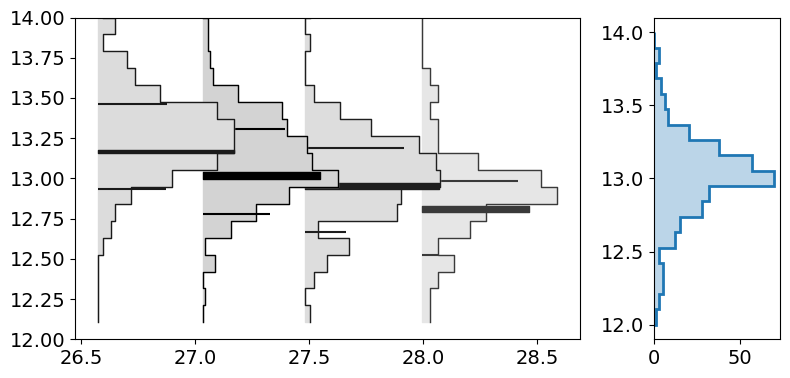

In [195]:
fig, axarr = plt.subplots(1,2,figsize=(8,4), gridspec_kw={'width_ratios':[4.,1.]})

thresh = 3.
detection = (uvsnr>thresh)&(hasnr>thresh)
xbins = np.linspace(np.log10(np.quantile(galex.loc[detection, 'LFUV'],.05)),28.5,5)
ybins = np.linspace(12.,14.,20)
ek.histstack(
    np.log10(galex.reindex(lha_df.index)['LFUV'])[detection],
    merr[detection],
    #density=True,
    xbins=xbins,
    ybins=ybins,
    ax=axarr[0]
)
out=ek.hist(
    leer,
    bins=ybins,
    orientation='horizontal',
    color='C0',
    alpha=0.3,
    lw=2,
    ax=axarr[1]
)

axarr[0].set_ylim(12.,14.)

plt.tight_layout ()

In [205]:
out[1]

[<Axes: >, <Axes: >, <Axes: >]

Text(0, 0.5, '$\\mathcal{R}$, catalog H$\\alpha$')

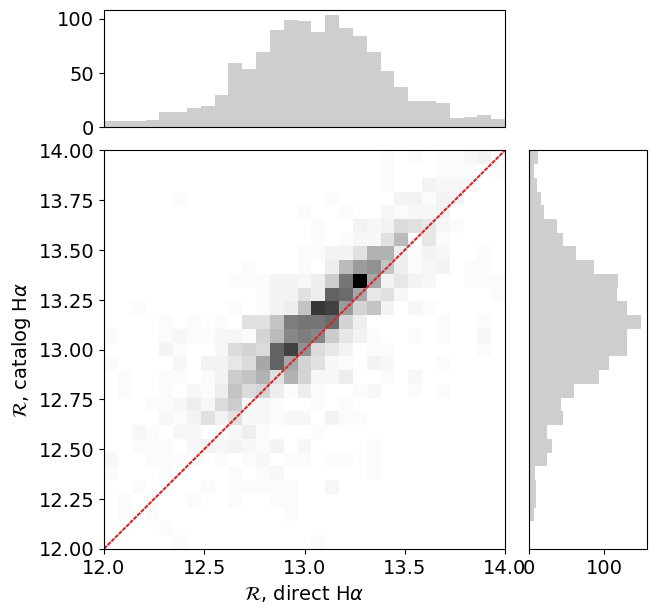

In [212]:
out,axarr=ek.hist2d(
    np.log10(lha_df['LHa']*1e40 / galex.reindex(lha_df.index)['LFUV']),
    np.log10(catalog_halum['LHa'] / galex.reindex(catalog_halum.index)['LFUV']),
    bins=[np.linspace(12.,14.,30),np.linspace(12.,14.,30)],
    show_proj=True
)
xs = np.array([12.,14.])
axarr[0].plot(xs,xs,color='tab:red', dashes=[2.,.5])
axarr[0].set_xlabel(r'$\mathcal{R}$, direct H$\alpha$')
axarr[0].set_ylabel(r'$\mathcal{R}$, catalog H$\alpha$')